# **GCN модель для анализа поведения пользователей**

### Загрузка данных:
* Загружаются данные из CSV-файлов, включая информацию об узлах, рёбрах и ресурсах.
* Для узлов (пользователей) извлекаются такие признаки, как роль пользователя, количество логинов, уровень доступа и время с последнего входа.
* Для ресурсов вычисляются дополнительные признаки, такие как тип ресурса и уровень доступа.

In [6]:
import pandas as pd

# Пути к файлам
nodes_path = "data/nodes_test.csv"
resources_path = "data/resources_test.csv"
edges_path = "data/edges_test.csv"

# Загрузка данных
nodes_df = pd.read_csv(nodes_path)
resources_df = pd.read_csv(resources_path)
edges_df = pd.read_csv(edges_path, parse_dates=["timestamp"])

# Убедимся, что timestamp — это datetime
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')


### Исследование данных

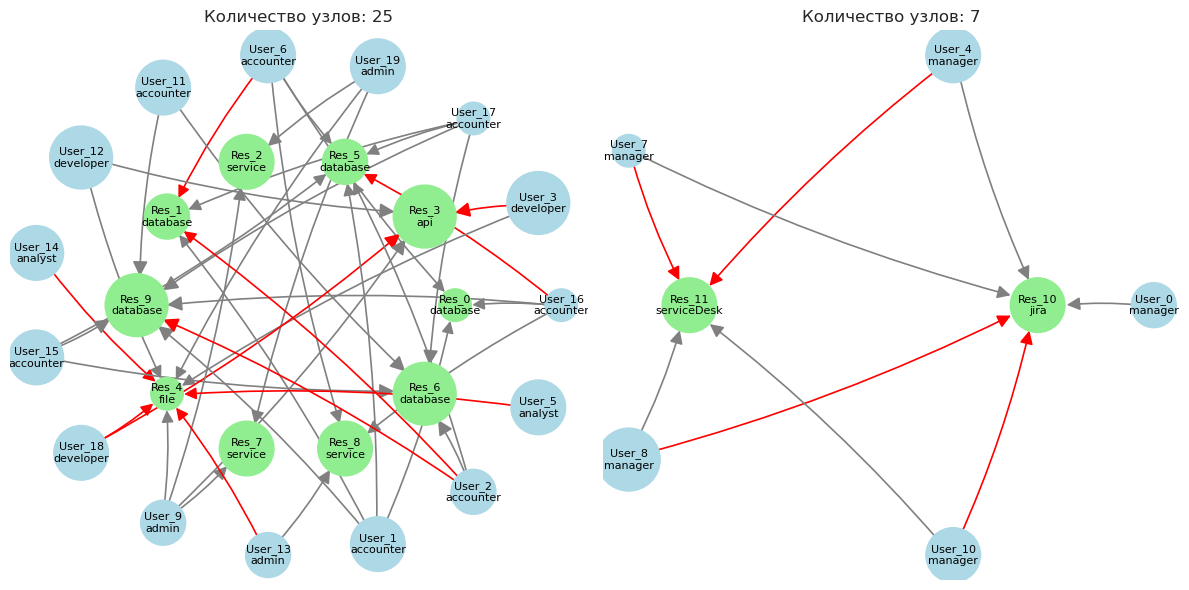

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from matplotlib.patches import FancyArrowPatch

# === Общие параметры ===
BASE_NODE_SIZE = 50
SCALE_NODE_FACTOR = 500
default_resource_radius = 3
default_user_radius = 5
start_hour = 9
end_hour = 18
offset = len(nodes_df)

# === Метаданные (Признаки узлов)===
user_access_levels = nodes_df.set_index('user_id')['access_level'].to_dict()
user_roles = nodes_df.set_index('user_id')['role'].to_dict()
resource_importance = resources_df.set_index('resource_id')['importance'].to_dict()
resource_types = resources_df.set_index('resource_id')['resource_type'].to_dict()

# === Определение нерабочего времени ===
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')
edges_df['is_after_hours'] = (
    (edges_df['timestamp'].dt.hour < start_hour) |
    (edges_df['timestamp'].dt.hour >= end_hour) |
    (edges_df['timestamp'].dt.weekday >= 5)
)
after_hours_edges = set([
    (row['source_user'], row['target_resource'] + offset)
    for _, row in edges_df[edges_df['is_after_hours']].iterrows()
])

# === Уникальные роли пользователей ===
unique_roles = nodes_df['role'].unique()

# === Построение графа ===
G = nx.DiGraph()
G.add_edges_from([
    (row['source_user'], row['target_resource'] + offset)
    for _, row in edges_df.iterrows()
])
components = list(nx.weakly_connected_components(G))

# === Визуализация ===
fig, axes = plt.subplots(1, len(components), figsize=(6 * len(components), 6))
if len(components) == 1:
    axes = [axes]

for ax, comp_nodes in zip(axes, components):
    H = G.subgraph(comp_nodes).copy()

    pos = {}
    resources = [n for n in H.nodes if n >= offset]
    users = [n for n in H.nodes if n < offset]

    # Ресурсы по окружности
    for i, r in enumerate(resources):
        angle = 2 * math.pi * i / len(resources)
        pos[r] = (default_resource_radius * math.cos(angle), default_resource_radius * math.sin(angle))

    # Пользователи по внешнему кругу
    for i, u in enumerate(users):
        angle = 2 * math.pi * i / len(users)
        pos[u] = (default_user_radius * math.cos(angle), default_user_radius * math.sin(angle))

    labels = {
        n: f"User_{n}\n{user_roles.get(n, '')}" if n < offset
        else f"Res_{n - offset}\n{resource_types.get(n - offset, '')}"
        for n in H.nodes
    }
    sizes = [
        BASE_NODE_SIZE + SCALE_NODE_FACTOR * user_access_levels.get(n, 1)
        if n < offset else BASE_NODE_SIZE + SCALE_NODE_FACTOR * resource_importance.get(n - offset, 1)
        for n in H.nodes
    ]
    colors = ['lightblue' if n < offset else 'lightgreen' for n in H.nodes]
    node_size_map = dict(zip(H.nodes, sizes))

    # Узлы
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=sizes, ax=ax)

    # Рёбра
    for (u, v) in H.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        dx, dy = x2 - x1, y2 - y1
        dist = math.hypot(dx, dy)
        if dist == 0:
            continue

        ru = math.sqrt(node_size_map[u]) / 200
        rv = math.sqrt(node_size_map[v]) / 200

        factor_u = 1.1 + 0.3 * min(1, 100 / dist)
        factor_v = 2.3  # увеличенный отступ от ресурсов

        r1 = ru * factor_u
        r2 = rv * factor_v

        sx = x1 + dx * r1 / dist
        sy = y1 + dy * r1 / dist
        tx = x2 - dx * r2 / dist
        ty = y2 - dy * r2 / dist

        # Цвет стрелки: красный — нерабочее время, серый — обычное
        edge_color = 'red' if (u, v) in after_hours_edges else 'gray'

        arrow = FancyArrowPatch((sx, sy), (tx, ty),
                                connectionstyle="arc3,rad=0.05",
                                arrowstyle='-|>',
                                color=edge_color,
                                mutation_scale=max(18, rv * 100),
                                linewidth=1.2)
        ax.add_patch(arrow)

    # Подписи
    nx.draw_networkx_labels(H, pos, labels, ax=ax, font_size=8)
    ax.set_title(f"Количество узлов: {len(H.nodes)}")
    ax.axis('off')

plt.tight_layout()
plt.show()



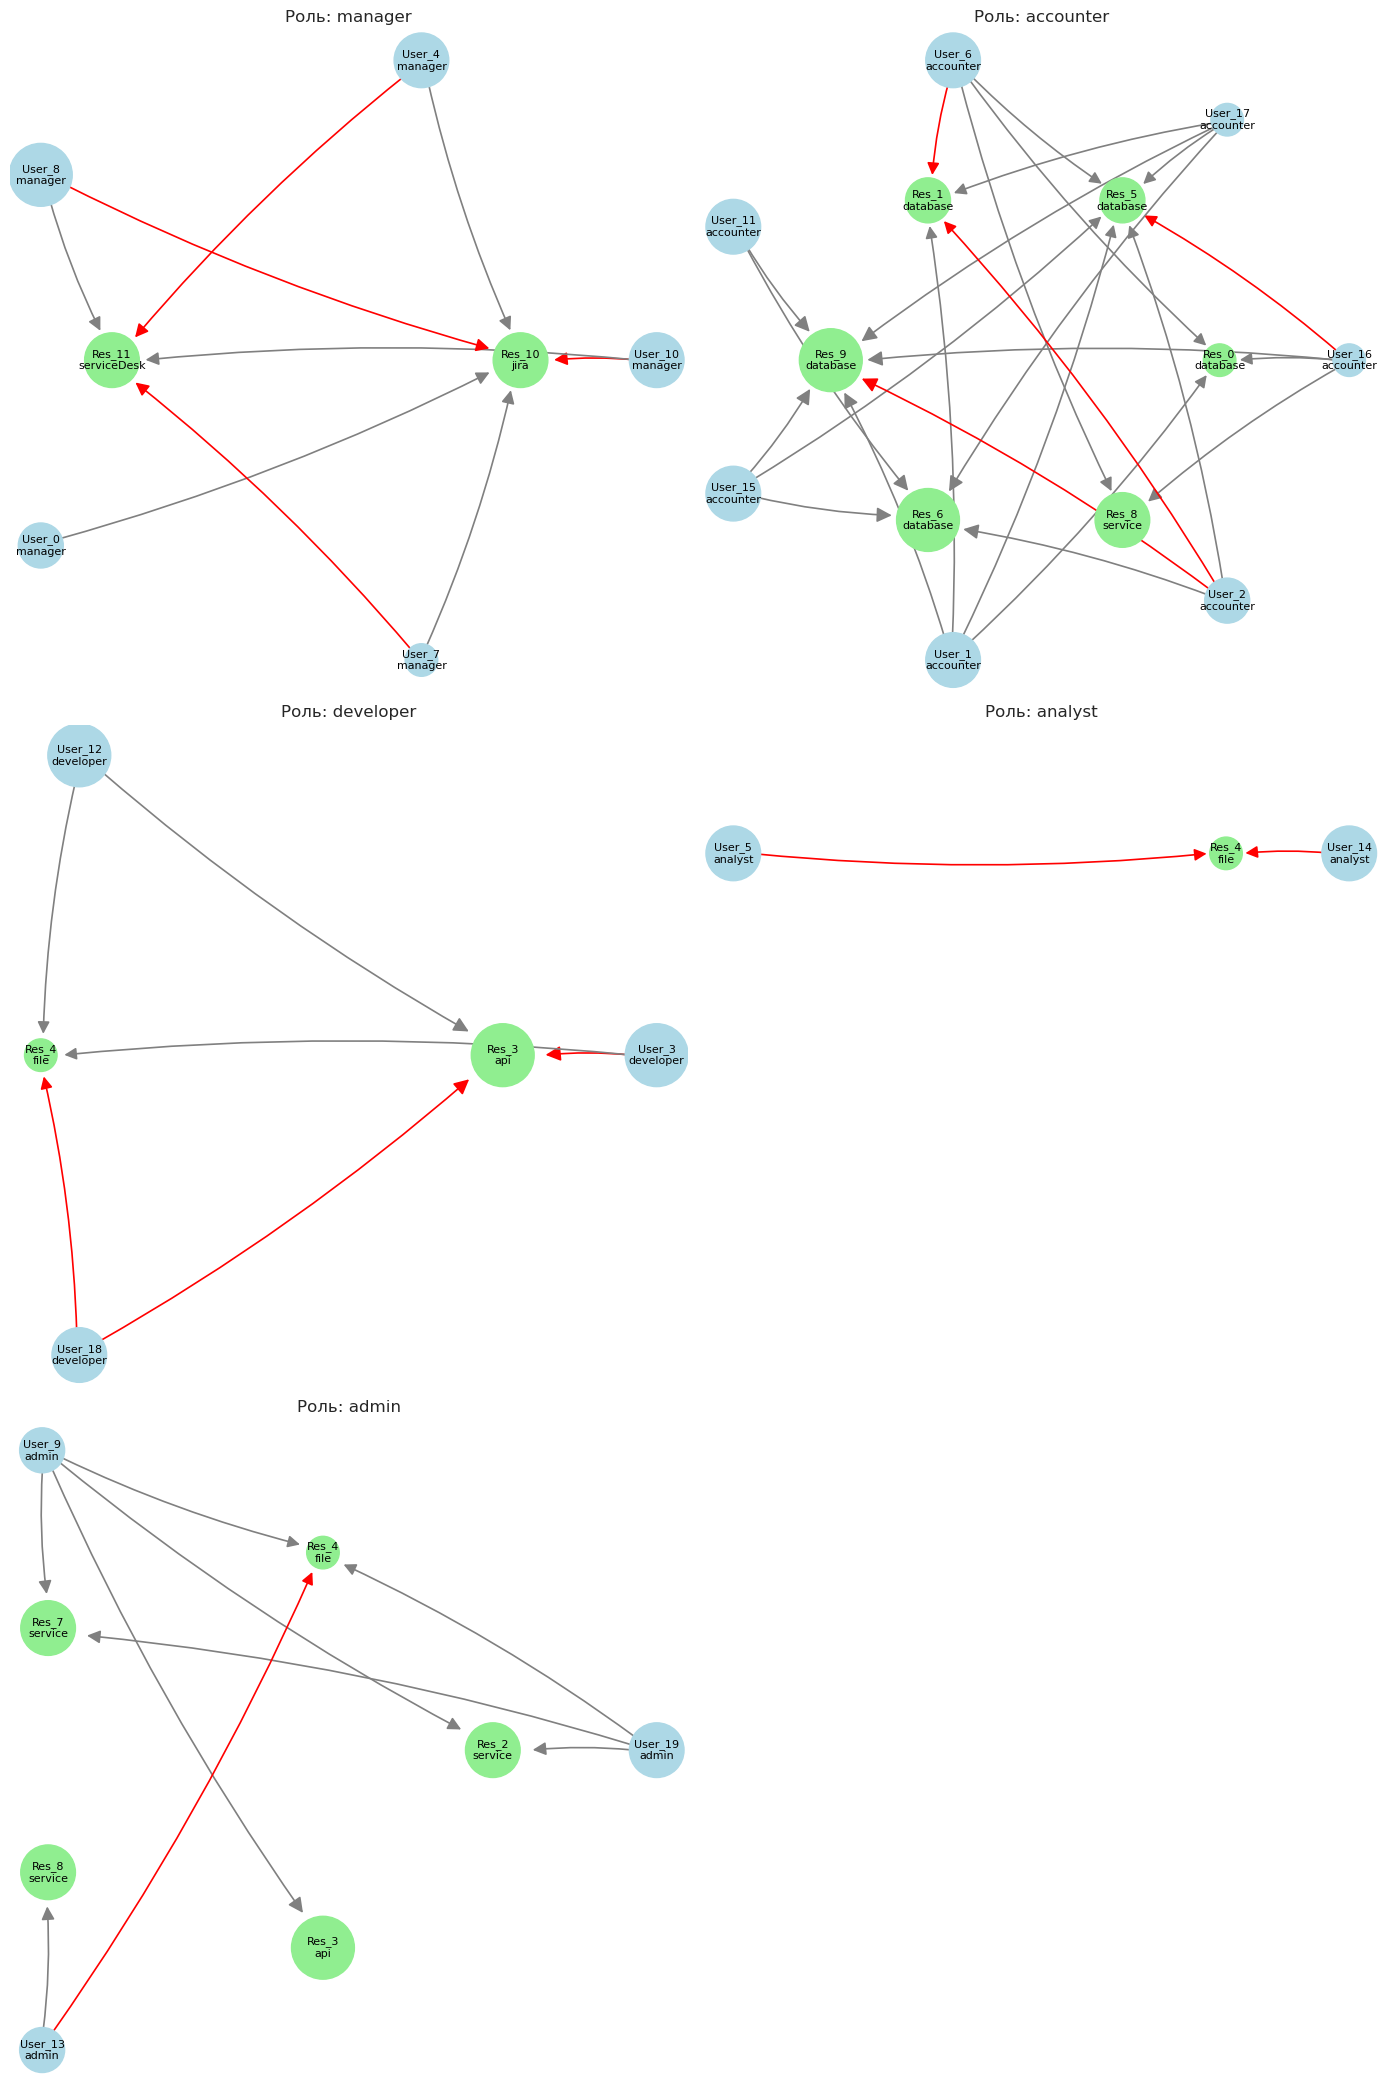

In [8]:
graph_data = []

for role in unique_roles:
    role_users_df = nodes_df[nodes_df['role'] == role]
    role_user_ids = set(role_users_df['user_id'])

    role_edges_df = edges_df[edges_df['source_user'].isin(role_user_ids)]
    role_resource_ids = set(role_edges_df['target_resource'])
    role_resources_df = resources_df[resources_df['resource_id'].isin(role_resource_ids)]

    G = nx.DiGraph()
    for _, row in role_edges_df.iterrows():
        G.add_edge(row['source_user'], row['target_resource'] + offset)

    if len(G.nodes) == 0:
        continue

    graph_data.append((role, G, role_edges_df))

# === Визуализация: 2 графа на строку ===
fig, axes = plt.subplots(nrows=math.ceil(len(graph_data) / 2), ncols=2, figsize=(14, 7 * math.ceil(len(graph_data) / 2)))
axes = axes.flatten()

for idx, (role, G, role_edges_df) in enumerate(graph_data):
    ax = axes[idx]
    pos = {}
    users = [n for n in G.nodes if n < offset]
    resources = [n for n in G.nodes if n >= offset]

    for i, r in enumerate(resources):
        angle = 2 * math.pi * i / len(resources)
        pos[r] = (default_resource_radius * math.cos(angle), default_resource_radius * math.sin(angle))

    for i, u in enumerate(users):
        angle = 2 * math.pi * i / len(users)
        pos[u] = (default_user_radius * math.cos(angle), default_user_radius * math.sin(angle))

    labels = {
        n: f"User_{n}\n{user_roles.get(n, '')}" if n < offset
        else f"Res_{n - offset}\n{resource_types.get(n - offset, '')}"
        for n in G.nodes
    }

    sizes = [
        BASE_NODE_SIZE + SCALE_NODE_FACTOR * user_access_levels.get(n, 1)
        if n < offset else BASE_NODE_SIZE + SCALE_NODE_FACTOR * resource_importance.get(n - offset, 1)
        for n in G.nodes
    ]
    colors = ['lightblue' if n < offset else 'lightgreen' for n in G.nodes]
    node_size_map = dict(zip(G.nodes, sizes))

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, ax=ax)

    for (u, v) in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        dx, dy = x2 - x1, y2 - y1
        dist = math.hypot(dx, dy)
        if dist == 0:
            continue

        ru = math.sqrt(node_size_map[u]) / 200
        rv = math.sqrt(node_size_map[v]) / 200

        factor_u = 1.1 + 0.3 * min(1, 100 / dist)
        factor_v = 2.3

        r1 = ru * factor_u
        r2 = rv * factor_v

        sx = x1 + dx * r1 / dist
        sy = y1 + dy * r1 / dist
        tx = x2 - dx * r2 / dist
        ty = y2 - dy * r2 / dist

        edge_color = 'red' if (u, v) in set((row['source_user'], row['target_resource'] + offset)
                                            for _, row in role_edges_df[role_edges_df['is_after_hours']].iterrows()) else 'gray'

        arrow = FancyArrowPatch((sx, sy), (tx, ty),
                                connectionstyle="arc3,rad=0.05",
                                arrowstyle='-|>',
                                color=edge_color,
                                mutation_scale=max(18, rv * 100),
                                linewidth=1.2)
        ax.add_patch(arrow)

    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    ax.set_title(f"Роль: {role}")
    ax.axis('off')

# Отключить пустые оси
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1139661/480381649.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


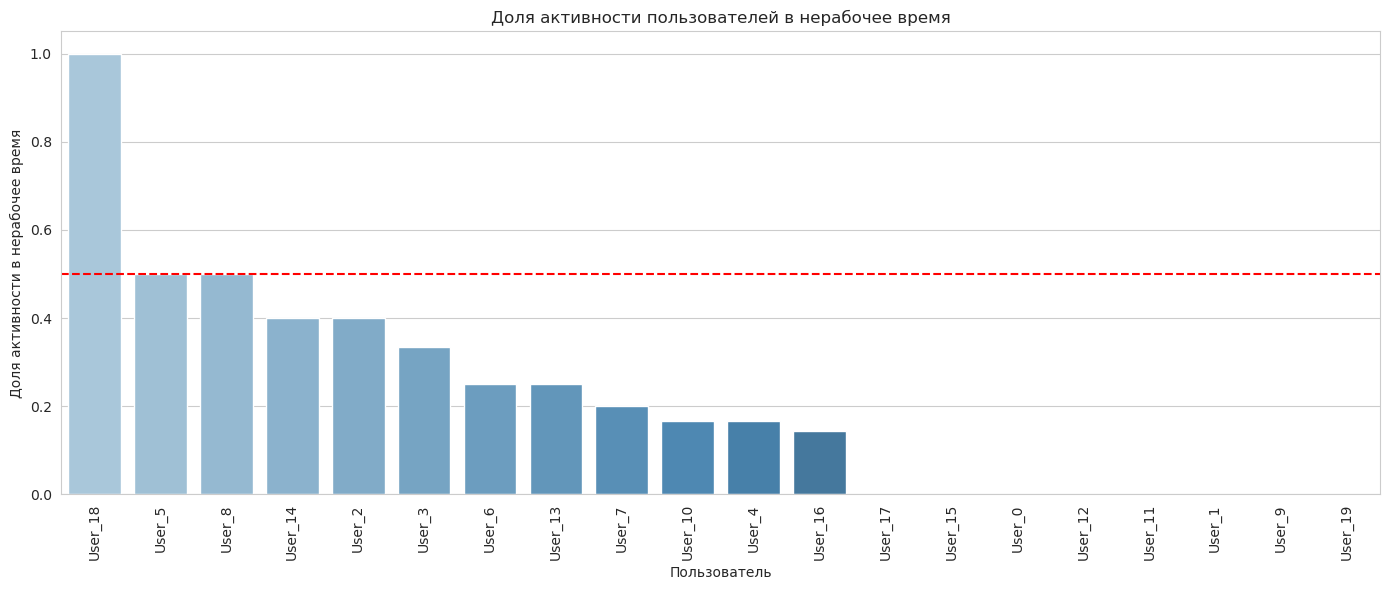

In [9]:
import seaborn as sns
# Подсчёт общего количества событий и количества в нерабочее время
total_events = edges_df.groupby("source_user").size().reset_index(name="total_events")
after_hours_events = edges_df[edges_df["is_after_hours"]].groupby("source_user").size().reset_index(name="after_hours_events")

# Объединение
activity_ratio_df = pd.merge(total_events, after_hours_events, on="source_user", how="left").fillna(0)
activity_ratio_df["after_hours_ratio"] = activity_ratio_df["after_hours_events"] / activity_ratio_df["total_events"]

# Добавим имена пользователей
activity_ratio_df = activity_ratio_df.merge(nodes_df[["user_id", "name"]], left_on="source_user", right_on="user_id", how="left")

# Сортировка по доле
activity_ratio_df = activity_ratio_df.sort_values(by="after_hours_ratio", ascending=False)

# Построение графика
plt.figure(figsize=(14, 6))
sns.barplot(
    x=activity_ratio_df["name"],
    y=activity_ratio_df["after_hours_ratio"],
    palette="Blues_d"
)
# Горизонтальная линия на уровне 0.5
plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label="Порог 50%")

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("Доля активности в нерабочее время")
plt.title("Доля активности пользователей в нерабочее время")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1139661/3057828454.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_counts_full = pd.DataFrame(index=nodes_df["name"], columns=['access', 'modification', 'deletion']).fillna(0)


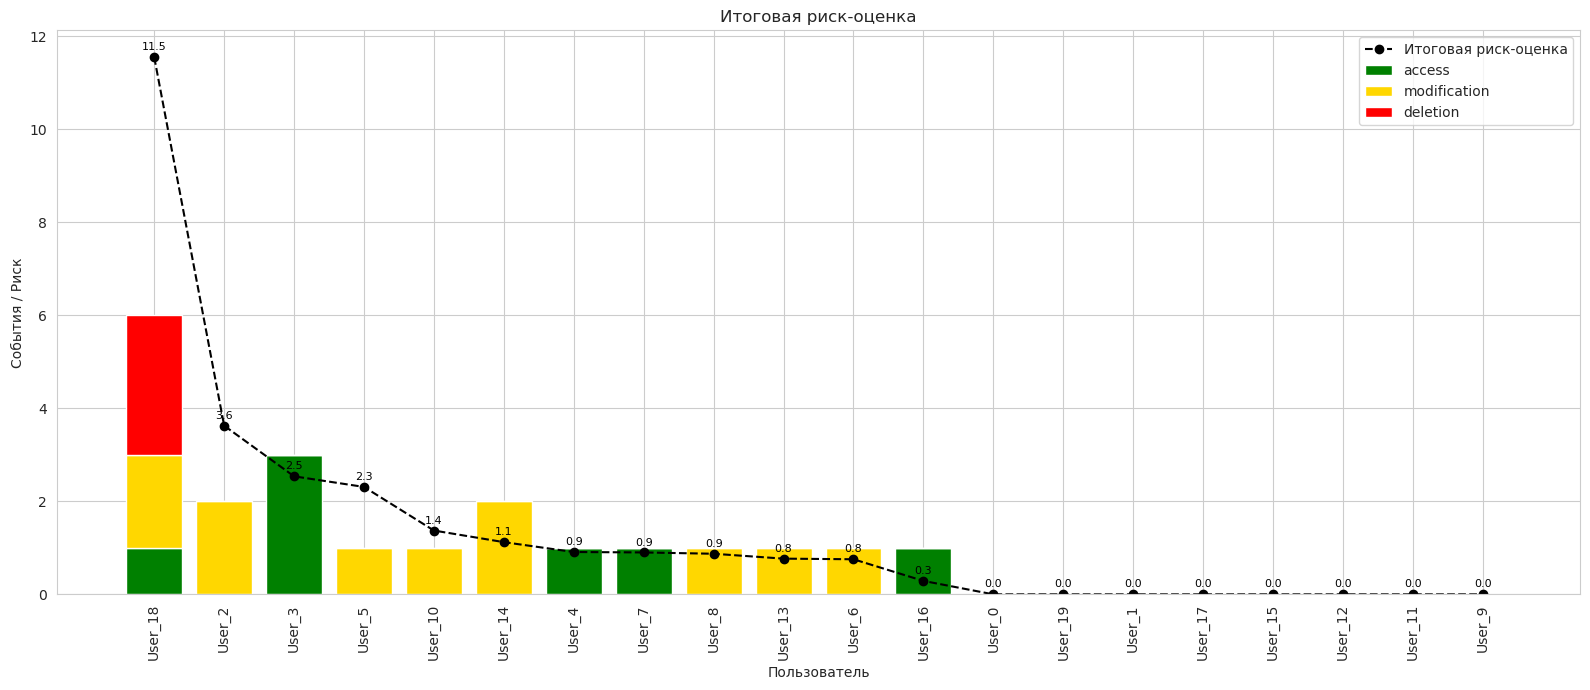

/tmp/ipykernel_1139661/3057828454.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


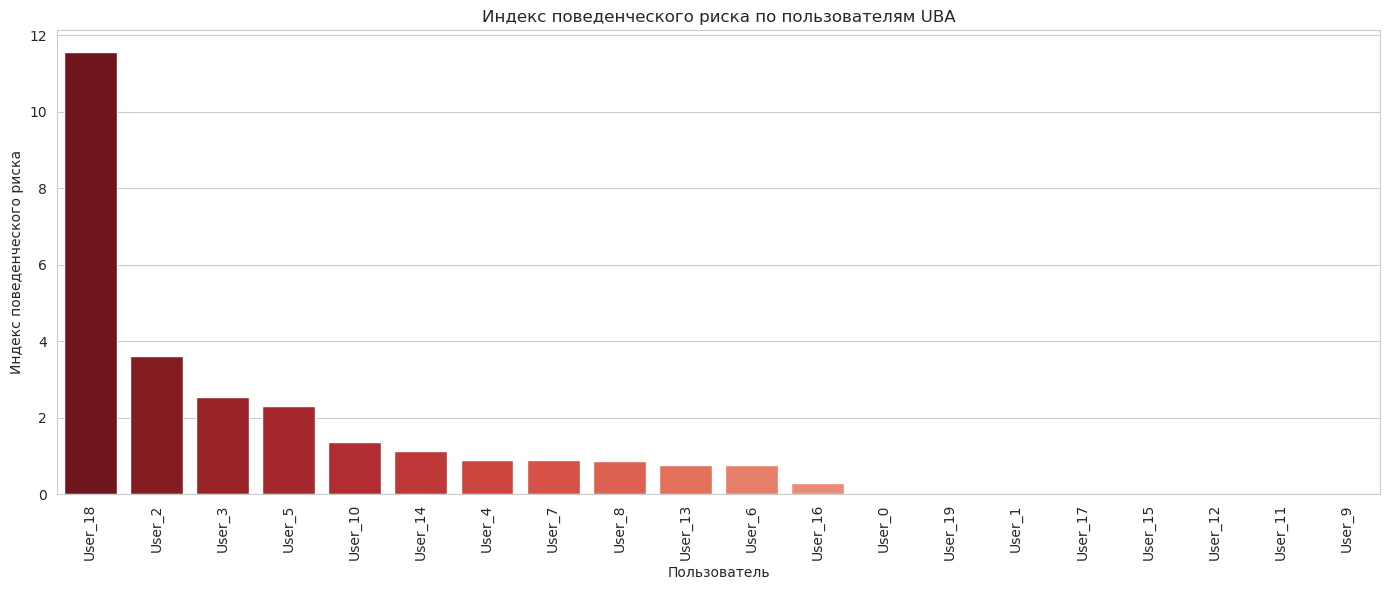

In [10]:
# === Расчёт итоговой риск-оценки ===
all_events_df = edges_df[edges_df["is_after_hours"]].copy()
all_events_df = all_events_df.merge(nodes_df[["user_id", "access_level"]], left_on="source_user", right_on="user_id", how="left")
all_events_df = all_events_df.merge(resources_df[["resource_id", "access_level"]],
                                    left_on="target_resource", right_on="resource_id", how="left",
                                    suffixes=("_user", "_resource"))
all_events_df["access_violation"] = (all_events_df["access_level_user"] < all_events_df["access_level_resource"]).astype(int)

# Коэффициенты по типам событий
event_weights = {"access": 0.5, "modification": 1.0, "deletion": 1.0}
all_events_df["event_type_weight"] = all_events_df["event_type"].map(event_weights)

# Формула итоговой риск-оценки
all_events_df["event_risk"] = (
    all_events_df["event_type_weight"] *
    all_events_df["weight"] *
    all_events_df["access_level_user"] *
    (1 + all_events_df["access_violation"])
)

# Группировка по пользователям
final_risk_scores = all_events_df.groupby("source_user")["event_risk"].sum().reset_index(name="final_risk_score")
user_risk_df = nodes_df.merge(final_risk_scores, left_on="user_id", right_on="source_user", how="left").fillna(0)
user_risk_df["final_risk_score"] = user_risk_df["final_risk_score"]

# === Подсчёт событий по типам для всех пользователей ===
after_hours_df = edges_df[edges_df["is_after_hours"]].merge(nodes_df[["user_id", "name"]],
                                                             left_on="source_user", right_on="user_id", how="left")
event_counts = after_hours_df.groupby(['name', 'event_type']).size().unstack(fill_value=0)
for col in ['access', 'modification', 'deletion']:
    if col not in event_counts.columns:
        event_counts[col] = 0

event_counts_full = pd.DataFrame(index=nodes_df["name"], columns=['access', 'modification', 'deletion']).fillna(0)
event_counts_merged = event_counts_full.add(event_counts, fill_value=0)

# Добавим итоговую риск-оценку
event_counts_merged["risk_score"] = user_risk_df.set_index("name")["final_risk_score"]
event_counts_sorted = event_counts_merged.sort_values(by="risk_score", ascending=False)

# === Визуализация ===
plt.figure(figsize=(16, 7))

plt.bar(event_counts_sorted.index, event_counts_sorted['access'], color='green', label='access')
plt.bar(event_counts_sorted.index, event_counts_sorted['modification'],
        bottom=event_counts_sorted['access'], color='gold', label='modification')
plt.bar(event_counts_sorted.index, event_counts_sorted['deletion'],
        bottom=event_counts_sorted['access'] + event_counts_sorted['modification'],
        color='red', label='deletion')

plt.plot(event_counts_sorted.index, event_counts_sorted["risk_score"],
         color='black', marker='o', linestyle='--', label='Итоговая риск-оценка')

# Подписи к точкам риска
for i, value in enumerate(event_counts_sorted["risk_score"]):
    plt.annotate(f'{value:.1f}', xy=(i, value), xytext=(0, 5),
                 textcoords="offset points", ha='center', fontsize=8, color='black')

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("События / Риск")
plt.title("Итоговая риск-оценка")
plt.legend()
plt.tight_layout()
plt.show()


# Построим диаграмму риск-оценки: поведенческий риск — пользователь
plt.figure(figsize=(14, 6))
sns.barplot(
    x=event_counts_sorted.index,
    y=event_counts_sorted["risk_score"],
    palette="Reds_r"
)

plt.xticks(rotation=90)
plt.xlabel("Пользователь")
plt.ylabel("Индекс поведенческого риска")
plt.title("Индекс поведенческого риска по пользователям UBA")
plt.tight_layout()
plt.show()
